# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve


# !pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
#keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1
VALIDATION_SPLIT_SIZE = .2

**XGBoost**

Extreme Gradient Boosting (xgboost) is an advanced implementation of the gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. 

Some key benefits of XGBoost are:

- Regularization - helps in reducing overfitting

- Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

- Handling Missing Values - It has an in-built routine to handle missing values.

- Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process


For this part I will perform the following steps:
- Evaluate the XGBoost model for the different word embeddings
- Tune the regularization strength parameter with cross-validated grid-search for each type of embeddings
- Check the predictions against the actual values
- Compare the results for the different word embeddings

**Hyperparameter Tuning**

XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. I used these guides for ideas on how to tune the model:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

**Quick note on the method**

In an ideal world, with infinite resources and where time is not an issue, I could run a giant grid search with all the parameters together and find the optimal solution. In fact, I gave it a try: using TFIDF I managed to find the optimal parameters after about 8 hours. For Word2Vec and using the same searh space as here I had to give up after 20 hours. Perhaps it is still doable with really small datasets, but for this dataset (which is by far not the largest), the training time was growing exponentially, and each step in the tuning process was becoming more and more expensive. 

In practice this approach is rarely feasible, so instead I'll go through the parameters one or two at a time. After careful reading, I decided to tune 5 of the hyperparameters that usually have a big impact on the performance. In theory it would be necessary to test all combinations to ensure we find THE optimal solution, but here I will try to find a good enough one by improving the model with a reasonable number of steps.

I somehow wanted to still give it a try using GridSearchCV as well, so I decided to try using a smaller search space. Interestingly enough, although the parameters I found here by manual trials were in the search space, GridSearchCV found different best parameters. Even though the parameters found were different, the results are the same. This tells us that tuning the parameters has little influence on the results, and the quality of the results is mostly influenced by the size and quality of the data set, and there isn't much more that can be done to improve these results.


**Approach for Parameter Tuning**

- Choose a relatively high learning rate. The default learning rate of 0.3 used at this stage. 

- Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

- Tune the learning rate.

- Finally tune gamma to avoid overfitting (optional).

- Determine the optimum number of trees. XGBoost also has its own cv function which performs cross-validation at each boosting iteration and returns the optimum number of trees required. I will set a very high number of trees (or num_boost_round in XGBoost terminology and rely on early stopping.

**Using XGBoost’s CV**

In order to tune the hyperparameters, I will use the cv function from XGBoost. It allows  to run cross-validation on the training dataset and returns a score (either built-in or customly defined).
It requires the following inputs:
- params: dictionary of parameters.
- dtrain matrix.
- num_boost_round: number of boosting rounds. Here I will use a large number and count on early_stopping_rounds to find the optimal number of rounds before reaching the maximum.
- seed: random seed. It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.
- nfold: the number of folds to use for cross-validation. Setting this to 5, same as for the other classifiers.
- metrics: the metrics to use to evaluate the model. For this part I have defined a custom F1 score metric, since XGBoost does not have one natively, and I wanted to compare to other classifiers using the same metric.


**A note about num_boost_round and early_stopping_rounds**

XGBoost is a gradient boosting method, as such it adds trees in every iteration to improve the prediction accuracy (performance). 

The prediction performance increases when you add more and more trees until it starts to overfit, at which point the it will start to decrease. So we need to find that optimum number of trees. It is basically impossible to guess this number, and this is what XGBoost.cv is for. It partitions the training data into two subsets. The first subset is used to train XGBoost, the second is used as a validation set. After each iteration (which adds an additional tree) XGBoost calculates the new validation error. With that XGBoost is able to detect when it starts to overfit (when the chosen evaluation metric starts to either increase (loss), or decrease (our custom F1 score)). This will give us the optimal number of trees for a given set of hyperparameters.

The num_boost_rounds (number of trees) parameter is not part of the PARAMETERS dictionary, but it is also a tunable parameter. num_boost_round corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters. This means it should be re-tuned each time we update a parameter. I could do this by tuning it together with all parameters in the grid-search, but it requires a lot of computational effort. Fortunately XGBoost provides a nice way to find the best number of rounds while training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/boost round improves performance. If the performance hasn’t improved for a specific number of rounds (as defined by the variable early_stopping_round), we stop the training and keep the best number of boosting rounds. 


I've decided here to use the XGBoost algorithm directly for tuning (mostly because it makes cross validation easy), there is also a scikit learn wrapper around XGBoost called XGBRegressor. The XGBoost algorithm is more customizeable, but the scikit learn wrapper plays more nicely with pipelines (and doesn't need DMatrix input).

***

**Utility Functions**

***

In [3]:
def custom_f1_score(preds, d_train):
    labels = d_train.get_label().astype(np.int)
    preds = (preds >= 0.5).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

In [4]:
# setup color scheme and standard figure size for all figures
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [6]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth=2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth=2, color=colors[6], linestyle=':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [7]:
def init_params():
#     Initialize with default parameters
    PARAMETERS['max_depth'] = 6
    PARAMETERS['min_child_weight'] = 1
    PARAMETERS['eta'] = .3
    PARAMETERS['subsample'] = 1
    PARAMETERS['colsample_bytree'] = 1
    return PARAMETERS

In [8]:
def cross_validation(PARAMETERS, d_train):
    cv_results = xgb.cv(PARAMETERS,
        d_train,
        feval = custom_f1_score,
        num_boost_round = NUM_BOOST_ROUNDS,
        maximize = True,
        seed = RANDOM_SEED,
        nfold = 5,
        early_stopping_rounds = EARLY_STOPPING_ROUNDS
    )
    return cv_results

***

**TF-IDF**

***

**Prepare the data set and DMatrices**

In [9]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [10]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [11]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [12]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (54706, 25000) float64
y: (54706,) int64


In [13]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (7599, 25000) float64
y: (7599,) int64


In [14]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (13677, 25000) float64
y: (13677,) int64


Instead of numpy arrays or pandas data frames, XGBoost uses DMatrices. A DMatrix can contain both the features and the target. The data is already loaded into arrays, so I can use them to create the DMatrix. 

In [15]:
# A DMatrix can contain both the features and the target.
d_train_tfidf = xgb.DMatrix(x_train_tfidf, label = y_train_tfidf) 
d_test_tfidf = xgb.DMatrix(x_test_tfidf, label = y_test_tfidf)
d_val_tfidf = xgb.DMatrix(x_val_tfidf, label = y_val_tfidf)
watchlist_tfidf = [(d_train_tfidf, 'train'), (d_val_tfidf, 'val')]

In [16]:
# Initialize with default parameters
PARAMETERS = {
     'objective':'binary:logistic',
     'max_depth': 6,
     'min_child_weight': 1,
     'eta': .3,
     'subsample': 1,
     'colsample_bytree': 1,
     'verbosity': 0 # add this line to slient warning message
  }

In [17]:
RANDOM_SEED = 12
NUM_BOOST_ROUNDS = 1000
EARLY_STOPPING_ROUNDS = 20

**Tune max_depth and min_child_weight** 

I'll tune these concurrently using a basic grid search, meaning I'll test all combinations of the two variables in a certain range. Whichever combination has the best cross validation score, will be set as values for the next round.


- max_depth is the largest depth allowed on any decision tree in the ensemble, where tree depth is the number of nodes from the root down to the farthest away leaf. Larger max_depth values allow for more complex trees, which means a larger chance of capturing complicated features but also a larger chance of overfitting.
- min_child_weight is a regularization factor that changes how often tree nodes split in tree creation. Only nodes with a hessian (second order partial derivative) larger than min_child_weight are allowed to split. Smaller min_child_weight values mean more complex trees, and therefore more chance of overfitting.

In [18]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)
    
    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.9642224 reached after 566 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.9639492000000001 reached after 590 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.9613791999999999 reached after 456 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.9654366 reached after 415 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.9629768000000001 reached after 304 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.9638832 reached after 355 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.965192 reached after 281 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.963808200000000

In [19]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

**Tune subsample and colsample**

- subsample is the fraction of datapoints (rows of the training data) to sample at each round (each tree), with 0 meaning no rows are sampled and 1 meaning all rows are sampled. The higher the value, the more likely to overfit the data.
- colsample_bytree is the fraction of features (columns of the training data) to sample at each round (each tree), with 0 meaning no columns are sampled and 1 meaning all columns are sampled. The higher the value, the more likely to overfit the data.

In [20]:
# Tuning subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)] 
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.9600892 reached after 283 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.9600630000000001 reached after 333 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.9576927999999999 reached after 218 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.9578936 reached after 200 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.9588958 reached after 261 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.9608292 reached after 272 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.9617634 reached after 379 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.7
	F1

In [21]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

**Tune eta**

Eta in XGBoost works the same way as a learning_rate, in the sense that it controls how quickly each step changes. The smaller the eta, the smaller each step, which means the algorithm will likely take more steps to converge.

In [22]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.9651875999999999 reached after 346 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.9644278 reached after 405 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.9650994 reached after 756 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.960369 reached after 824 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.0 reached after 0 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.0 reached after 0 rounds
Best params: 0.3, F1 Score: 0.9651875999999999


In [23]:
# Update eta.
PARAMETERS['eta'] = best_params

Let’s have a look at the final list of tuned parameters.

In [24]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 5,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 0.9,
 'colsample_bytree': 0.6,
 'verbosity': 0}

Finally I can now use these tuned parameters in the xgboost model. I will set a very high num_boost_round and rely on early stopping to stop the model if its performance doesn’t improve in 20 rounds.

In [25]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_tfidf,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_tfidf,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval=True)

[0]	train-logloss:0.54971	train-f1_score:0.43028	val-logloss:0.55204	val-f1_score:0.41267
[1]	train-logloss:0.49928	train-f1_score:0.78267	val-logloss:0.50237	val-f1_score:0.78020
[2]	train-logloss:0.42672	train-f1_score:0.83831	val-logloss:0.43205	val-f1_score:0.83177
[3]	train-logloss:0.39814	train-f1_score:0.84939	val-logloss:0.40475	val-f1_score:0.84214
[4]	train-logloss:0.37660	train-f1_score:0.86036	val-logloss:0.38405	val-f1_score:0.85108
[5]	train-logloss:0.33842	train-f1_score:0.88765	val-logloss:0.34758	val-f1_score:0.87982
[6]	train-logloss:0.31394	train-f1_score:0.90161	val-logloss:0.32429	val-f1_score:0.89382
[7]	train-logloss:0.30179	train-f1_score:0.90322	val-logloss:0.31340	val-f1_score:0.89403
[8]	train-logloss:0.28606	train-f1_score:0.90856	val-logloss:0.29843	val-f1_score:0.89942
[9]	train-logloss:0.27280	train-f1_score:0.91031	val-logloss:0.28593	val-f1_score:0.90194
[10]	train-logloss:0.26180	train-f1_score:0.91527	val-logloss:0.27670	val-f1_score:0.90694
[11]	trai

[91]	train-logloss:0.10362	train-f1_score:0.97235	val-logloss:0.14765	val-f1_score:0.94975
[92]	train-logloss:0.10296	train-f1_score:0.97256	val-logloss:0.14725	val-f1_score:0.94909
[93]	train-logloss:0.10255	train-f1_score:0.97263	val-logloss:0.14690	val-f1_score:0.94925
[94]	train-logloss:0.10176	train-f1_score:0.97300	val-logloss:0.14646	val-f1_score:0.94956
[95]	train-logloss:0.10099	train-f1_score:0.97327	val-logloss:0.14596	val-f1_score:0.94947
[96]	train-logloss:0.10053	train-f1_score:0.97334	val-logloss:0.14539	val-f1_score:0.94968
[97]	train-logloss:0.10004	train-f1_score:0.97346	val-logloss:0.14512	val-f1_score:0.95012
[98]	train-logloss:0.09939	train-f1_score:0.97389	val-logloss:0.14480	val-f1_score:0.95013
[99]	train-logloss:0.09884	train-f1_score:0.97427	val-logloss:0.14447	val-f1_score:0.95034
[100]	train-logloss:0.09812	train-f1_score:0.97433	val-logloss:0.14422	val-f1_score:0.95066
[101]	train-logloss:0.09762	train-f1_score:0.97440	val-logloss:0.14386	val-f1_score:0.950

[181]	train-logloss:0.06430	train-f1_score:0.98594	val-logloss:0.12393	val-f1_score:0.95738
[182]	train-logloss:0.06406	train-f1_score:0.98603	val-logloss:0.12380	val-f1_score:0.95752
[183]	train-logloss:0.06378	train-f1_score:0.98621	val-logloss:0.12371	val-f1_score:0.95782
[184]	train-logloss:0.06326	train-f1_score:0.98602	val-logloss:0.12342	val-f1_score:0.95775
[185]	train-logloss:0.06307	train-f1_score:0.98607	val-logloss:0.12324	val-f1_score:0.95781
[186]	train-logloss:0.06285	train-f1_score:0.98614	val-logloss:0.12303	val-f1_score:0.95796
[187]	train-logloss:0.06246	train-f1_score:0.98616	val-logloss:0.12287	val-f1_score:0.95803
[188]	train-logloss:0.06225	train-f1_score:0.98645	val-logloss:0.12278	val-f1_score:0.95824
[189]	train-logloss:0.06200	train-f1_score:0.98648	val-logloss:0.12268	val-f1_score:0.95818
[190]	train-logloss:0.06174	train-f1_score:0.98661	val-logloss:0.12263	val-f1_score:0.95818
[191]	train-logloss:0.06137	train-f1_score:0.98675	val-logloss:0.12254	val-f1_sc

[271]	train-logloss:0.04326	train-f1_score:0.99284	val-logloss:0.11447	val-f1_score:0.96083
[272]	train-logloss:0.04309	train-f1_score:0.99284	val-logloss:0.11448	val-f1_score:0.96068
[273]	train-logloss:0.04290	train-f1_score:0.99291	val-logloss:0.11445	val-f1_score:0.96053
[274]	train-logloss:0.04265	train-f1_score:0.99286	val-logloss:0.11431	val-f1_score:0.96075
[275]	train-logloss:0.04244	train-f1_score:0.99298	val-logloss:0.11422	val-f1_score:0.96105
[276]	train-logloss:0.04232	train-f1_score:0.99304	val-logloss:0.11421	val-f1_score:0.96135
[277]	train-logloss:0.04216	train-f1_score:0.99304	val-logloss:0.11401	val-f1_score:0.96150
[278]	train-logloss:0.04205	train-f1_score:0.99304	val-logloss:0.11394	val-f1_score:0.96158
[279]	train-logloss:0.04186	train-f1_score:0.99311	val-logloss:0.11389	val-f1_score:0.96157
[280]	train-logloss:0.04166	train-f1_score:0.99313	val-logloss:0.11362	val-f1_score:0.96193
[281]	train-logloss:0.04140	train-f1_score:0.99324	val-logloss:0.11334	val-f1_sc

In [26]:
# XGBoost returns probabilities by default.
y_probas_train_tfidf = xgb_model.predict(d_train_tfidf)
y_probas_test_tfidf = xgb_model.predict(d_test_tfidf)

In [27]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf)

True Negatives:  3549
False Positives:  161
False Negatives:  125
True Positives:  3764


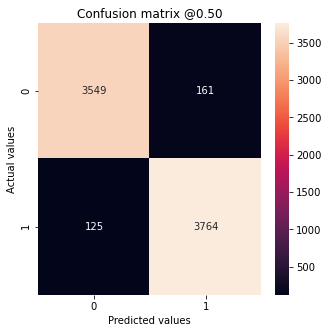

In [28]:
plot_cfm(y_test_tfidf, y_probas_test_tfidf)

In [29]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3710
           1       0.96      0.97      0.96      3889

    accuracy                           0.96      7599
   macro avg       0.96      0.96      0.96      7599
weighted avg       0.96      0.96      0.96      7599



Compared to the other models, which seemed to concentrate on maximing either one of precision or recall, at the cost of the other, XGBoost achieves similar scores for both precision and recall (for both classes).


The XGBoost model got 78% of the test set majority class right, but struggles to recognize the minority class (bullying comments), with only 150 comments predicted correctly.

In [30]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average='weighted')
print('F1: %.2f' % f1_tfidf)

F1: 0.96


In [31]:
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc_tfidf)

AUC: 0.99


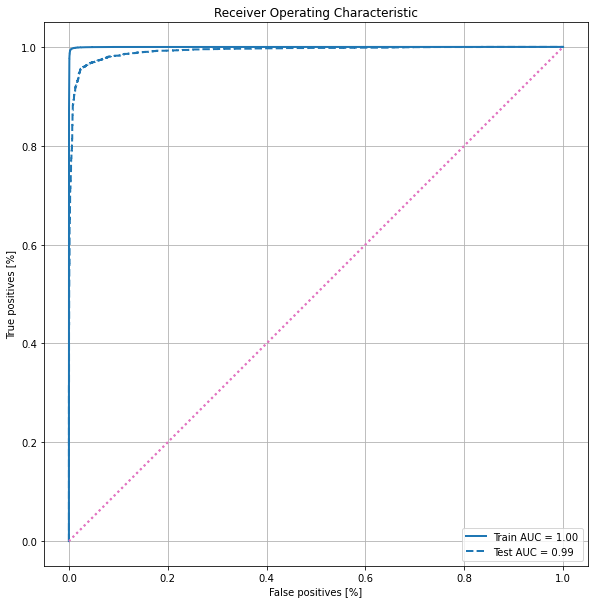

In [32]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

In [33]:
import joblib
# save
joblib.dump(xgb_model, "./xgb.joblib")

['./xgb.joblib']

In [34]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
import pickle
pickle.dump(xgb_model, open('xgb.pkl','wb'))